In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import torch
import os

from helpers.composite_helpers import *


from numba import cuda 


In [2]:


"""
"""
"""
COMPUTING PARAMETERS
"""
"""
"""

os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

torch.manual_seed(8)
np.random.seed(8)


Using device: cuda


In [3]:
"""
"""
"""
RUN PARAMETERS
"""
"""
"""

# directories

curtains_dir = "/global/home/users/rrmastandrea/curtains/fresh/"

n_points = 100000
n_features = 5
dataset_config_string = f"LHCO_minmax_bidirectional/"

exp_dir = os.path.join(curtains_dir, dataset_config_string)
data_dir = os.path.join(curtains_dir, dataset_config_string, "data")

print("Making results directory at", exp_dir, "...")
os.makedirs(exp_dir, exist_ok=True)

data_dir = os.path.join(exp_dir, "data")


# dataset generation parameters
context_endpoints = (3000, 4000)


bands_dict = {"ob1": [3000, 3200],
              "sb1": [3200, 3400],
              "sr" : [3400, 3600],
              "sb2": [3600, 3800],
              "ob2": [3800, 4000]}

binning_scheme = np.linspace(-4, 4, 50)


Making results directory at /global/home/users/rrmastandrea/curtains/fresh/LHCO_minmax_bidirectional/ ...


In [4]:
"""
"""
"""
LOAD IN THE DATASETS AND PROCESS
"""
"""
"""

dataset_sim = ToyDataset(data_dir, "data_sim.npy")
dataset_dat = ToyDataset(data_dir, "data_dat.npy")
               

print("Num SIM events:", len(dataset_sim))
print("Num DAT events:", len(dataset_dat))
print()

# Pull data from SB1 + SB2
training_dataset_sim = dataset_sim.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
training_dataset_dat = dataset_dat.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])

print("SIM sb1 + sb2 shape:", len(training_dataset_sim))
print("DAT sb1 + sb2 shape:", len(training_dataset_dat))
print()

# Preprocess the data
print("Preproccessing data...")
print()
training_dataset_sim.minmaxscale()
training_dataset_dat.minmaxscale()


# split into train val
val_split = 0.2

sim_val_size = int(val_split * len(training_dataset_sim))
dat_val_size = int(val_split * len(training_dataset_dat))

sim_train_size = len(training_dataset_sim) - sim_val_size
dat_train_size = len(training_dataset_dat) - dat_val_size


sim_train_dataset, sim_val_dataset = torch.utils.data.random_split(training_dataset_sim, [sim_train_size, sim_val_size])
dat_train_dataset, dat_val_dataset = torch.utils.data.random_split(training_dataset_dat, [dat_train_size, dat_val_size])

Num SIM events: 999986
Num DAT events: 999881

SIM sb1 + sb2 shape: 124815
DAT sb1 + sb2 shape: 124562

Preproccessing data...



In [8]:

"""
"
"
LOAD SIM BASE DENSITY
"
"
"""

# Training the BD
# This will be the upper subdirectory in saved_models/

num_layers_BD_sim = 8
num_hidden_features_BD_sim = 64
hyperparameters_dict_BD_sim = {"n_epochs": 50,
                              "batch_size": 128,
                              "lr": 0.0001,
                              "weight_decay": 0.0001}

exp_id_BD_sim = f"BDSIM_Masked_PRQ_AR_{num_layers_BD_sim}layers_{num_hidden_features_BD_sim}hidden_LRCos" 

# Define a flow architecture
transforms_BD = make_masked_AR_flow(num_layers_BD_sim, n_features, num_hidden_features_BD_sim)
base_dist = ConditionalDiagonalNormal(shape=[n_features], context_encoder=nn.Linear(1, 2*n_features))



"""
"
"
LOAD DAT BASE DENSITY
"
"
"""

# Training s2d
# This will be another (of many) subdirectory in saved_models/

num_layers_BD_dat = 8
num_hidden_features_BD_dat = 64
hyperparameters_dict_BD_dat = {"n_epochs": 50,
                              "batch_size": 128,
                              "lr": 0.0001,
                              "weight_decay": 0.0001}

exp_id_BD_dat = f"BDDAT_Masked_PRQ_AR_{num_layers_BD_dat}layers_{num_hidden_features_BD_dat}hidden_LRCos" # to distingush the saved models

# Define a flow architecture
transforms_BD_dat = make_masked_AR_flow(num_layers_BD_dat, n_features, num_hidden_features_BD_dat)
base_dist_dat = ConditionalDiagonalNormal(shape=[n_features], context_encoder=nn.Linear(1, 2*n_features))




In [9]:

# Load in BD and s2d models
config_string_BD_sim = "epochs{0}_lr{1}_wd{2}_bs{3}".format(hyperparameters_dict_BD_sim["n_epochs"], hyperparameters_dict_BD_sim["lr"], hyperparameters_dict_BD_sim["weight_decay"], hyperparameters_dict_BD_sim["batch_size"])
config_string_BD_dat = "epochs{0}_lr{1}_wd{2}_bs{3}".format(hyperparameters_dict_BD_dat["n_epochs"], hyperparameters_dict_BD_dat["lr"], hyperparameters_dict_BD_dat["weight_decay"], hyperparameters_dict_BD_dat["batch_size"])

BD_sim_dir = os.path.join(exp_dir, f"saved_models_{exp_id_BD_sim}/")
checkpoint_path_BD_sim = os.path.join(BD_sim_dir, f"BDSIM_{config_string_BD_sim}")

BD_dat_dir = os.path.join(exp_dir, f"saved_models_{exp_id_BD_dat}/")
checkpoint_path_BD_dat = os.path.join(BD_dat_dir, f"BDDAT_{config_string_BD_dat}")

s2d_dir = os.path.join(exp_dir, f"simBD_to_datBD_transform/")
os.makedirs(s2d_dir, exist_ok=True)


print("Loading the models ...")
print()
flow_BD_sim = torch.load(f"{checkpoint_path_BD_sim}_best_model.pt")
flow_BD_dat = torch.load(f"{checkpoint_path_BD_dat}_best_model.pt")

# send network to device
flow_BD_sim.to(device)
flow_BD_dat.to(device)
# freeze the trained model
for param in flow_BD_sim.parameters():
    param.requires_grad = False
flow_BD_sim.eval()
for param in flow_BD_dat.parameters():
    param.requires_grad = False
flow_BD_dat.eval()


Loading the models ...



Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=5, out_features=64, bias=True)
          (context_layer): Linear(in_features=1, out_features=64, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (context_layer): Linear(in_features=1, out_features=64, bias=True)
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=64, out_features=64, bias=True)
                (1): MaskedLinear(in_features=64, out_features=64, bias=True)
              )
              (dropout): Dropout(p=0.05, inplace=False)
            )
            (1): MaskedResidualBlock(
              (context_layer): Linear(in_features=1, out_features=64, bias=True)
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=64, out_features=64

In [10]:
alpha = 0.4
bands_to_transform = list(bands_dict.keys())
    
sim_samples = {band:0 for band in bands_to_transform}
dat_samples = {band:0 for band in bands_to_transform}

sim_to_dat_samples = {band:0 for band in bands_to_transform}
dat_to_sim_samples = {band:0 for band in bands_to_transform}

normal_from_sim_samples = {band:0 for band in bands_to_transform}
normal_from_dat_samples = {band:0 for band in bands_to_transform}


for band in bands_to_transform:

    print("Making samples for band", band, "...")

    # get the sim sample
    eval_dataset_sim = dataset_sim.pull_from_mass_range([bands_dict[band]])
    eval_dataset_sim.minmaxscale()

    # get the dat sample
    eval_dataset_dat = dataset_dat.pull_from_mass_range([bands_dict[band]])
    eval_dataset_dat.minmaxscale()

    # transform the sim sample to dat 
    feat = eval_dataset_sim[:,:-1].float().to(device)
    cont = torch.reshape(eval_dataset_sim[:,-1], (-1, 1)).float().to(device)

    with torch.no_grad():
        normal_target_from_sim, _ = flow_BD_sim._transform(feat, context=flow_BD_sim._embedding_net(cont))
        normal_target_from_dat, _ = flow_BD_dat._transform(feat, context=flow_BD_dat._embedding_net(cont))
        
        dat_target_from_sim, _ = flow_BD_dat._transform.inverse(normal_target_from_sim, context=flow_BD_dat._embedding_net(cont))
        sim_target_from_dat, _ = flow_BD_sim._transform.inverse(normal_target_from_dat, context=flow_BD_sim._embedding_net(cont))
           
    
    sim_samples[band] = eval_dataset_sim[:,:-1].detach().cpu().numpy()
    dat_samples[band] = eval_dataset_dat[:,:-1].detach().cpu().numpy()

    sim_to_dat_samples[band] = dat_target_from_sim.detach().cpu().numpy()
    dat_to_sim_samples[band] = sim_target_from_dat.detach().cpu().numpy()

    normal_from_sim_samples[band] = normal_target_from_sim.detach().cpu().numpy()
    normal_from_dat_samples[band] = normal_target_from_dat.detach().cpu().numpy()

   



Making samples for band ob1 ...
Making samples for band sb1 ...
Making samples for band sr ...
Making samples for band sb2 ...
Making samples for band ob2 ...


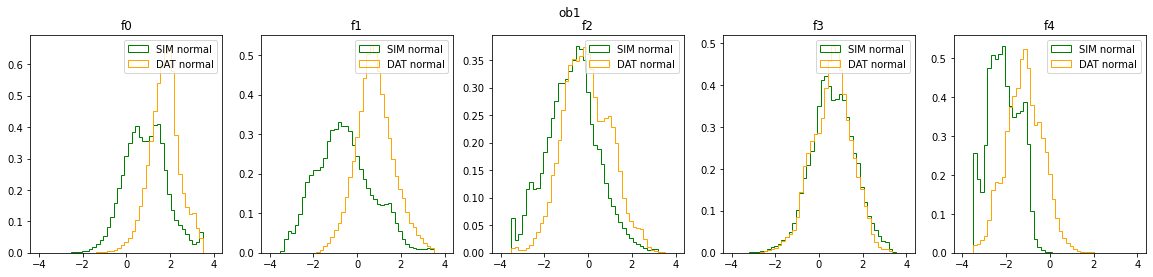

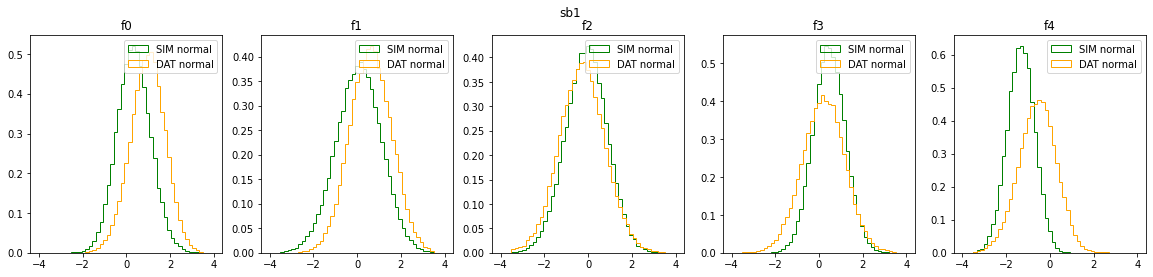

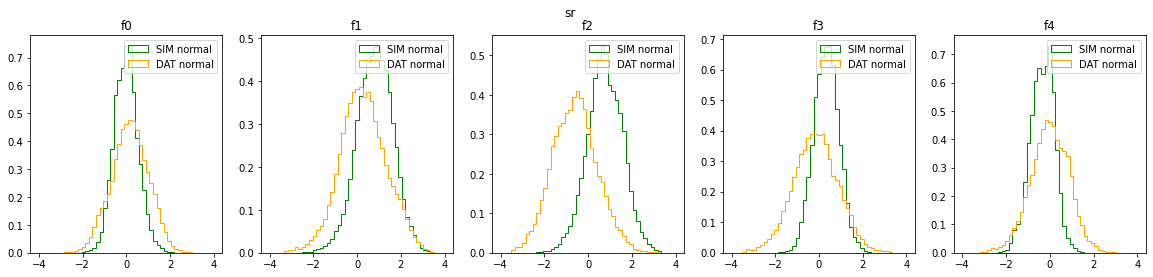

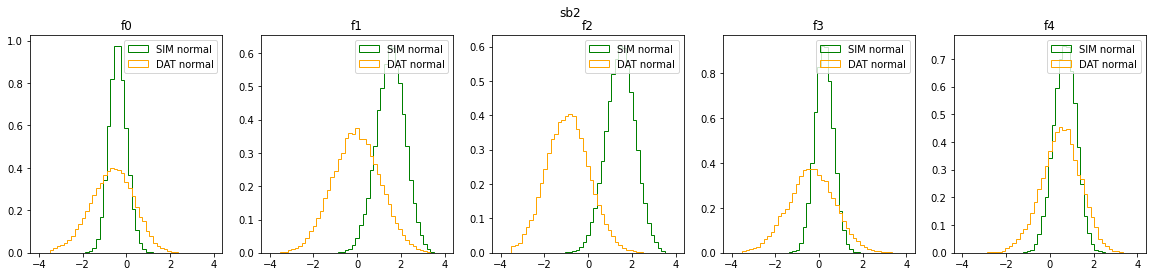

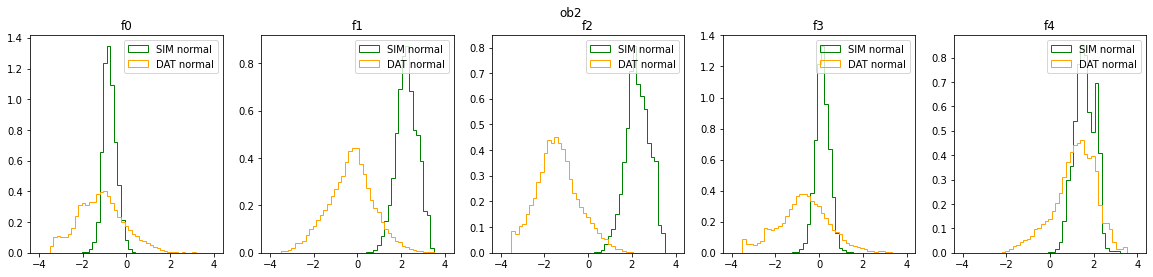

In [11]:
for band in bands_to_transform:
    fig, ax = plt.subplots(1, n_features, figsize = (4*(n_features), 4))
    for i in range(n_features):

        # Plots hists
        ax[i].hist(normal_from_sim_samples[band][:,i], bins = binning_scheme, label = "SIM normal", histtype = "step", color = "green", density = True)
        ax[i].hist(normal_from_dat_samples[band][:,i], bins = binning_scheme, label = "DAT normal", histtype = "step", color = "orange", density = True)

        ax[i].set_title(f"f{i}")
        ax[i].legend()

    fig.suptitle(band)
    fig.show()

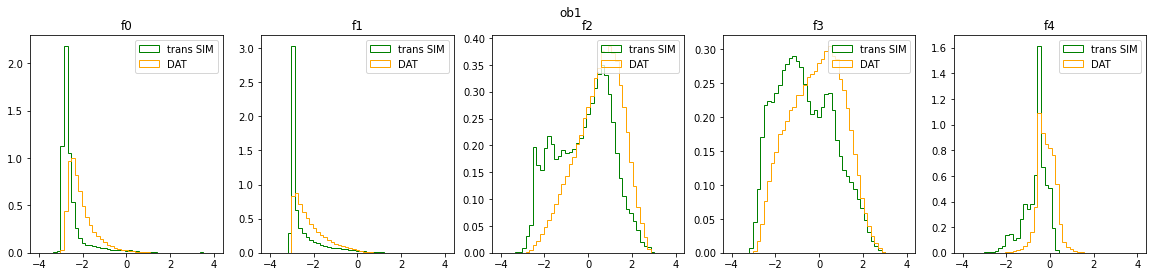

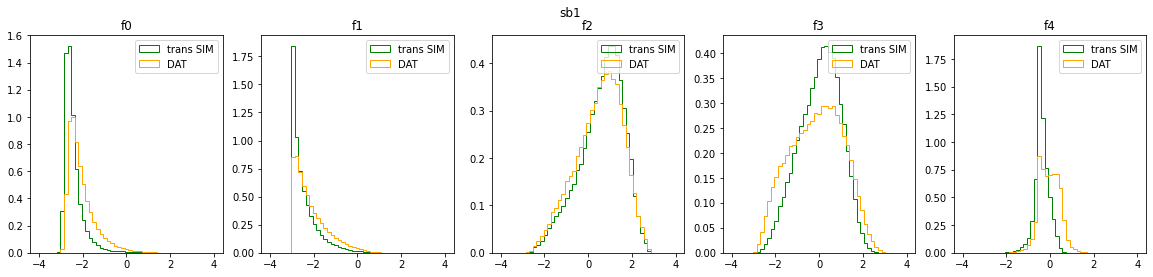

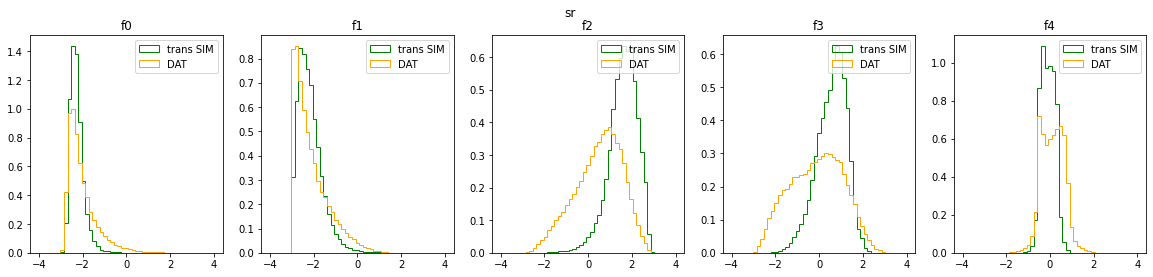

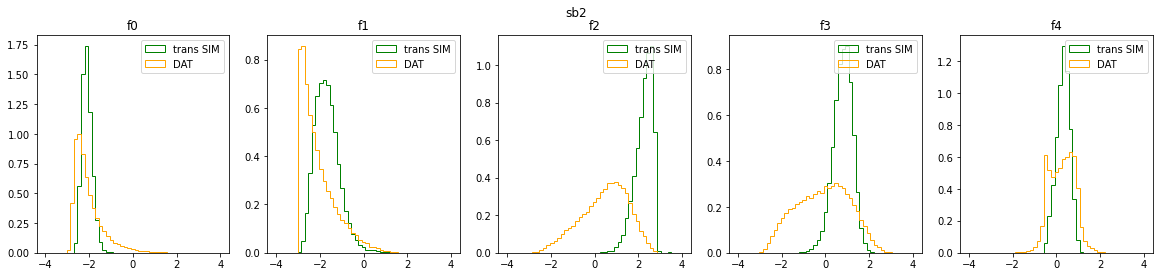

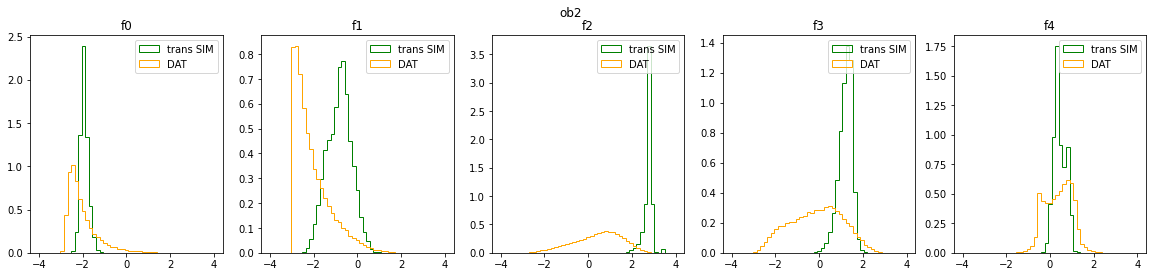

In [12]:
for band in bands_to_transform:
    # trans sim vs dat
    fig, ax = plt.subplots(1, n_features, figsize = (4*(n_features), 4))
    for i in range(n_features):

        # Plots hists
        ax[i].hist(sim_to_dat_samples[band][:,i], bins = binning_scheme, label = "trans SIM", histtype = "step", color = "green", density = True)
        ax[i].hist(dat_samples[band][:,i], bins = binning_scheme, label = "DAT", histtype = "step", color = "orange", density = True)

        ax[i].set_title(f"f{i}")
        ax[i].legend()

    fig.suptitle(band)
    fig.show()

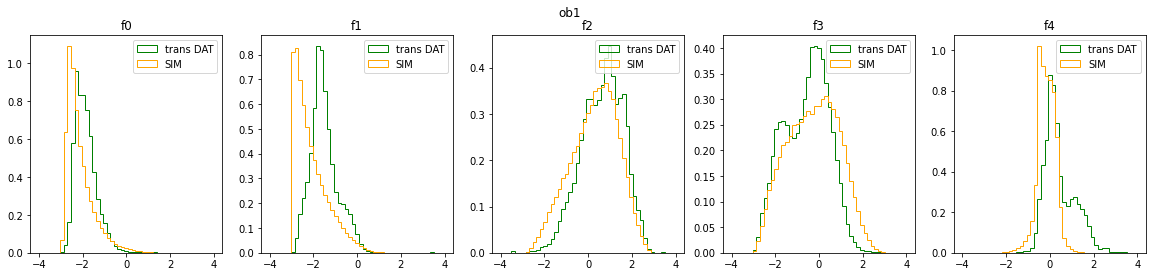

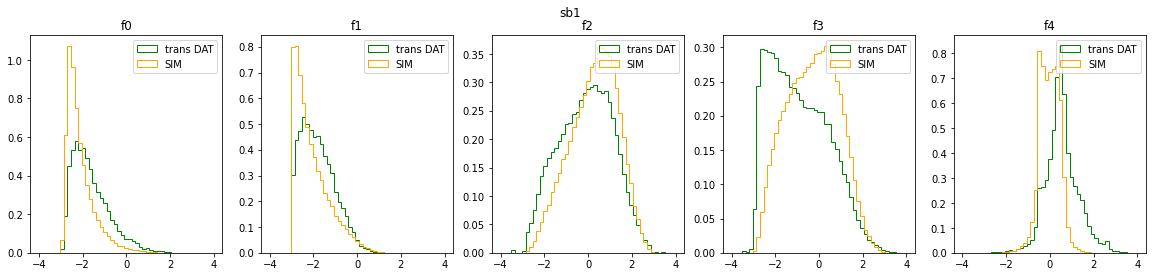

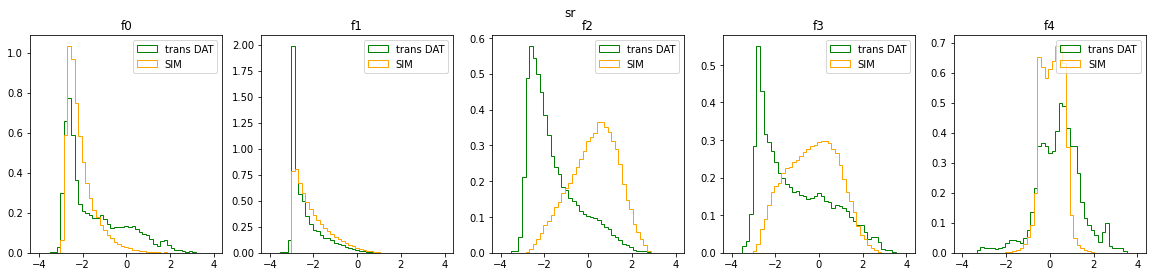

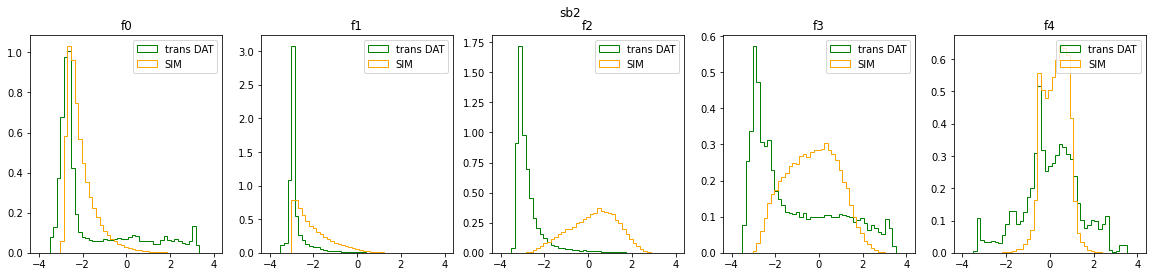

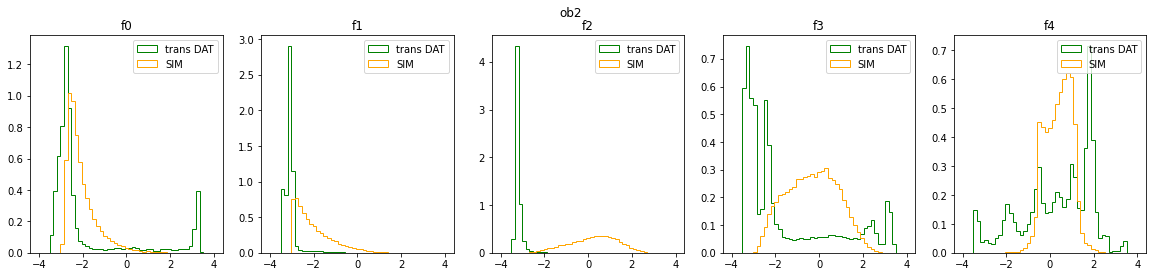

In [13]:
for band in bands_to_transform:
        # trans dat vs sim
    fig, ax = plt.subplots(1, n_features, figsize = (4*(n_features), 4))
    for i in range(n_features):

        # Plots hists
        ax[i].hist(dat_to_sim_samples[band][:,i], bins = binning_scheme, label = "trans DAT", histtype = "step", color = "green", density = True)
        ax[i].hist(sim_samples[band][:,i], bins = binning_scheme, label = "SIM", histtype = "step", color = "orange", density = True)

        ax[i].set_title(f"f{i}")
        ax[i].legend()

    fig.suptitle(band)
    fig.show()
